In [18]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.optim import Adam
from torch.distributions.normal import Normal
from tqdm import tqdm
from typing import Tuple, Optional

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

# Actor-Critic
class Actor(nn.Module):
    def __init__(self, obs_dim: int, hidden_dim: int, act_dim: int, dropout: float = 0.1):
        super().__init__()
        self.mu = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Tanh()
        )
        self.log_std = torch.nn.Parameter(torch.as_tensor(
            -0.5 * np.ones(act_dim, dtype=np.float32)
        ))

    def get_distribution(self, obs: Tensor) -> Normal:
        mu = self.mu(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    def forward(self, obs: Tensor, act: Optional[Tensor]) -> Tuple[Tensor, Optional[Tensor]]:
        dist = self.get_distribution(obs)
        log_prob = None
        if act is not None:
            log_prob = dist.log_prob(act).sum(axis=-1)
        return dist, log_prob

class Critic(nn.Module):
    def __init__(self, obs_dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, obs: Tensor) -> Tensor:
        return torch.squeeze(self.critic(obs), -1)

class A2CAgent:
    def __init__(self, env, state_size, action_size, hidden_size):
        self.env = env
        self.pi = Actor(state_size, hidden_size, action_size)
        self.v = Critic(state_size, hidden_size)
        self.pi_optim = Adam(self.pi.parameters(), lr=7e-3)
        self.v_optim = Adam(self.v.parameters(), lr=7e-3)
        self.gamma = 0.99

    def infer(self, obs: Tensor):
        with torch.no_grad():
            obs = torch.tensor([obs], dtype=torch.float)
            dist = self.pi.get_distribution(obs)
        return dist.loc

    def get_action(self, obs: Tensor):
        with torch.no_grad():
            obs = torch.tensor([obs], dtype=torch.float)
            dist = self.pi.get_distribution(obs)
            act = dist.sample()
        return act.squeeze().cpu().numpy()

    def train_step(self, obs, act, rew, next_obs, done):
        obs = torch.tensor([obs], dtype=torch.float)
        next_obs = torch.tensor([next_obs], dtype=torch.float)
        act = torch.tensor([act], dtype=torch.float)
        rew = torch.tensor([rew], dtype=torch.float)
        done = torch.tensor([done], dtype=torch.float)

        # 1-step actor critic
        curr_Q = self.v(obs)
        next_Q = self.v(next_obs)
        expected_Q = rew + self.gamma * next_Q * (1 - done)
        TD = expected_Q - curr_Q    # TD error: r_t + gamma * Q(s_t+1) - Q(s_t)

        v_loss = nn.MSELoss()(curr_Q, expected_Q.detach())
        self.v_optim.zero_grad()
        v_loss.backward()
        self.v_optim.step()

        dist, log_prob = self.pi(obs, act)
        pi_loss = -(log_prob * TD.detach()).mean()
        self.pi_optim.zero_grad()
        pi_loss.backward()
        self.pi_optim.step()

        return pi_loss.item(), v_loss.item()

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = gym.make("LunarLander-v3", continuous=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
hidden_size = 128
max_episodes = 1000

agent = A2CAgent(env, state_size, action_size, hidden_size)
agent.pi.apply(init_weights)
agent.v.apply(init_weights)

progress_bar = tqdm(range(max_episodes), desc="Training Progress")

state, info = env.reset(seed=seed)

num_steps = []
terminated = []
episode_mean_rewards = []

for episode in progress_bar:
    state, info = env.reset()
    num_step = 0
    episode_rew = 0
    term = False
    trunc = False

    while not (term or trunc):
        num_step += 1

        action = agent.get_action(state)
        next_state, reward, term, trunc, _ = env.step(action)
        pi_loss, v_loss = agent.train_step(state, action, reward, next_state, term | trunc)

        state = next_state
        episode_rew += reward

        if term or trunc:
            progress_bar.set_postfix({'Episode': episode + 1, 'Reward': episode_rew / num_step})
            num_steps.append(num_step)
            episode_mean_rewards.append(episode_rew / num_step)
            terminated.append(term)

Training Progress: 100%|██████████| 1000/1000 [13:08<00:00,  1.27it/s, Episode=1000, Reward=-2.75]


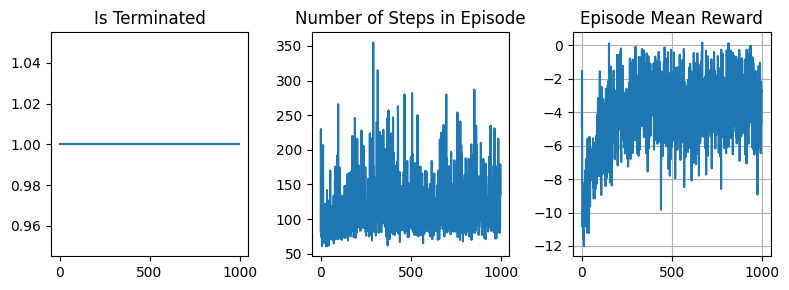

In [19]:
import matplotlib.pyplot as plt
from IPython import display
plt.ion()

fig, ax = plt.subplots(1,3, figsize=(8,3))
ax[0].plot(terminated)
ax[0].set_title("Is Terminated")
ax[1].plot(num_steps)
ax[1].set_title("Number of Steps in Episode")
ax[2].plot(episode_mean_rewards)
ax[2].set_title("Episode Mean Reward")
plt.tight_layout()
plt.grid()

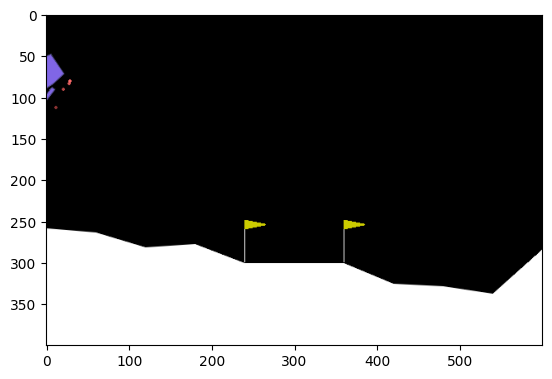

In [20]:
agent.pi.eval()
agent.v.eval()

env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")
state, info = env.reset(seed=42)
term = False
trunc = False

while not (term or trunc):
  action = agent.infer(state)
  state, reward, term, trunc, _ = env.step(action.squeeze().cpu().numpy())

  plt.imshow(env.render())
  display.display(plt.gcf())
  display.clear_output(wait=True)

env.close()
